# House Price Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
# supress warning, cuz why not
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv("bengaluru_house_prices.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df1.shape

(13320, 9)

In [4]:
df1.groupby('area_type')['area_type'].agg('count')

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [5]:
df2 = df1.drop(['area_type', 'availability', 'society', 'balcony'], axis='columns')
df2.shape

(13320, 5)

In [6]:
df2.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## Data Cleaning

### Find null values for all columns

In [7]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

### Drop all rows containing null cells

In [8]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [9]:
df3.shape

(13246, 5)

### Size column looks like it can be converted to only numerical data

In [10]:
df3['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [11]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(" ")[0]))

In [12]:
df3.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


### Exploring the total_sqft option

In [13]:
df3['bhk'].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [14]:
df3[df3.bhk>18]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
3379,1Hanuman Nagar,19 BHK,2000,16.0,490.0,19
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


### 43 bedrooms in 2400 sqft looks weird, seems like an error

In [15]:
df3['total_sqft'].unique()
# some values are in ranges

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

### Convert ranges to floating points

In [16]:
# To check if there are values other than float values
def check_num(x):
    try:
        float(x)
    except:
        return True
    return False

In [17]:
df3[df3['total_sqft'].apply(check_num)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [18]:
# this function will convert all ranges to floating points by taking their averages
# if it is just a number, a floating point will be returned
# if a string is found, return None, so that it can be removed later
def get_avg(x):
    ranges = x.split("-")
    if len(ranges) == 2:
        return (float(ranges[0])+float(ranges[1]))/2
    try:
        return float(x)
    except:
        return None

In [19]:
df4 = df3.copy()

In [20]:
df4['total_sqft'] = df4['total_sqft'].apply(get_avg)

In [21]:
df4.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [22]:
df4.isnull().sum()

location       0
size           0
total_sqft    46
bath           0
price          0
bhk            0
dtype: int64

In [23]:
df5 = df4.dropna()
df5.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
bhk           0
dtype: int64

### Beautiful

In [24]:
df5.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


In [25]:
df5.drop(['size'], axis='columns')
df5.shape

(13200, 6)

# Feature Engineering

### Price per sq ft

In [26]:
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [27]:
len(df5.location.unique())

1298

### Nearly 1300 unique locations, it is too much to deal with

In [28]:
df5['location'] = df5['location'].apply(lambda x: x.strip())
locations = df5.groupby('location')['location'].agg('count').sort_values(ascending=False)
locations

location
Whitefield              533
Sarjapur  Road          392
Electronic City         304
Kanakpura Road          264
Thanisandra             235
                       ... 
Kumbhena Agrahara         1
Kudlu Village,            1
Konappana Agrahara        1
Kodanda Reddy Layout      1
1 Annasandrapalya         1
Name: location, Length: 1287, dtype: int64

In [29]:
len(locations[locations<=10])

1047

### 1047 locations have only one value defined, amongst 1287 unique locations
### All of these locations can be put into the 'other' category to reduce data size

In [30]:
location_less_than_10 = locations[locations<=10]
location_less_than_10

location
Dodsworth Layout        10
BTM 1st Stage           10
Sadashiva Nagar         10
Thyagaraja Nagar        10
Kalkere                 10
                        ..
Kumbhena Agrahara        1
Kudlu Village,           1
Konappana Agrahara       1
Kodanda Reddy Layout     1
1 Annasandrapalya        1
Name: location, Length: 1047, dtype: int64

In [31]:
df5['location'] = df5['location'].apply(lambda x: 'other' if x in location_less_than_10 else x)

In [32]:
len(df5['location'].unique())

241

### 241 unique locations is much more feasible

In [33]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


### Examine total sqft of every bedroom
### Lets assume 300sqft to be an optimal size of every bedroom

In [34]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [35]:
# get rid of all this seemingly incorrect data
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

In [36]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

### minimum price is 267 and maximum is 176470
### this seems inconsistent, called 'outliers'

In [37]:
def remove_price_per_sqfft_outliers(x):
    out = pd.DataFrame()
    for key, df in x.groupby('location'):
        mean = np.mean(df.price_per_sqft)
        std_dev = np.std(df.price_per_sqft)
        reduced = df[(df.price_per_sqft>(mean-std_dev)) & (df.price_per_sqft<(mean+std_dev))]
        out = pd.concat([out,reduced], ignore_index=True)
    return out

df7 = remove_price_per_sqfft_outliers(df6)
df7.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


In [38]:
df7.price_per_sqft.describe()

count    10242.000000
mean      5657.735993
std       2266.368844
min       1250.000000
25%       4244.796706
50%       5172.846776
75%       6426.000592
max      24509.803922
Name: price_per_sqft, dtype: float64

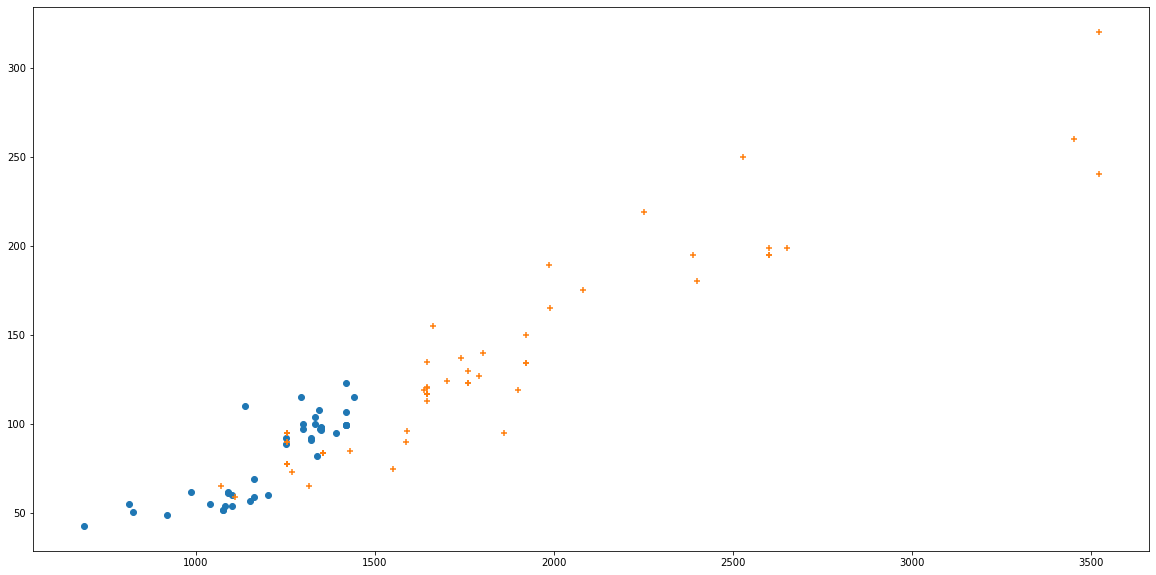

In [39]:
def plot_scatter_graph(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.scatter(bhk2.total_sqft,bhk2.price)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+')

plot_scatter_graph(df7,"Hebbal")

### Here we see some outliers, where 2BHK apt prices are more than 3BHK apts, even when the total sqft area is same

In [40]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
df8.shape

(7317, 7)

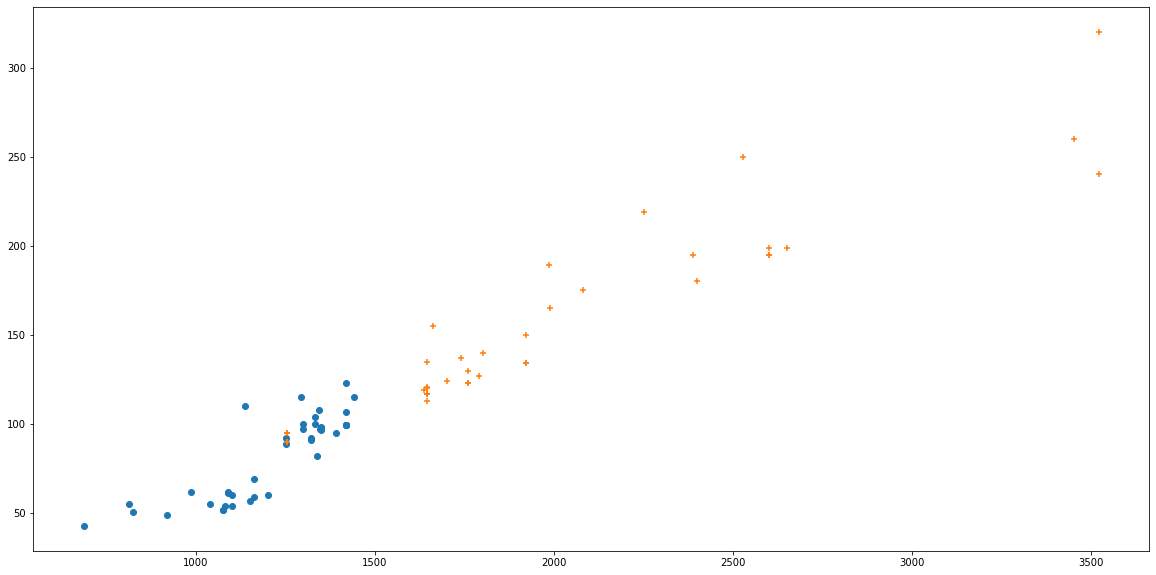

In [41]:
plot_scatter_graph(df8, "Hebbal")

<AxesSubplot:>

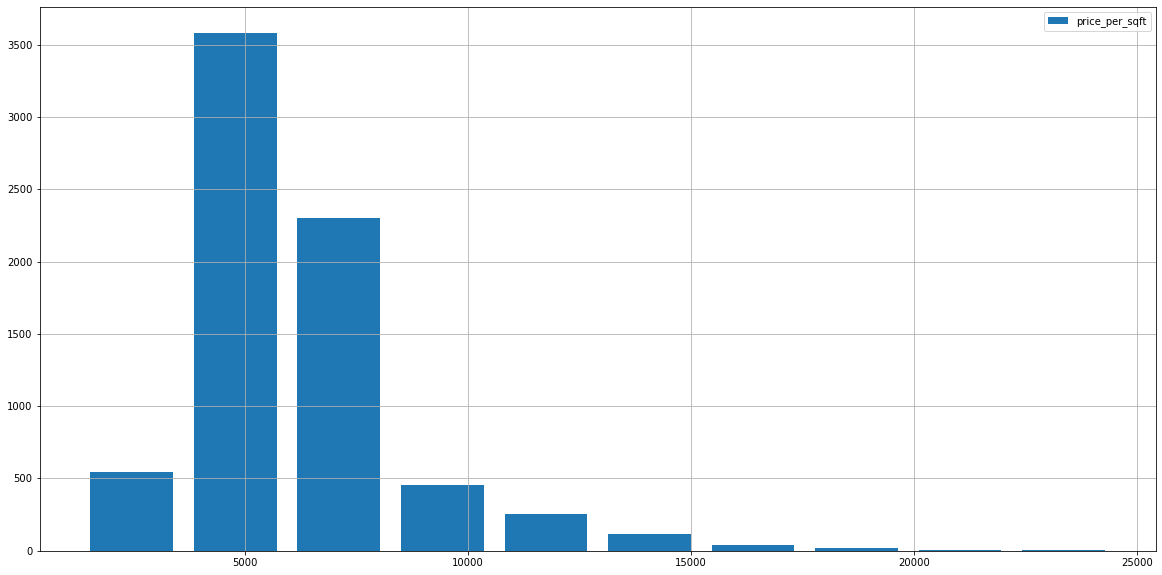

In [42]:
df8['price_per_sqft'].hist(rwidth=0.8, legend=True)

In [43]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

### Some houses have upto 16 bathrooms

In [44]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


<AxesSubplot:>

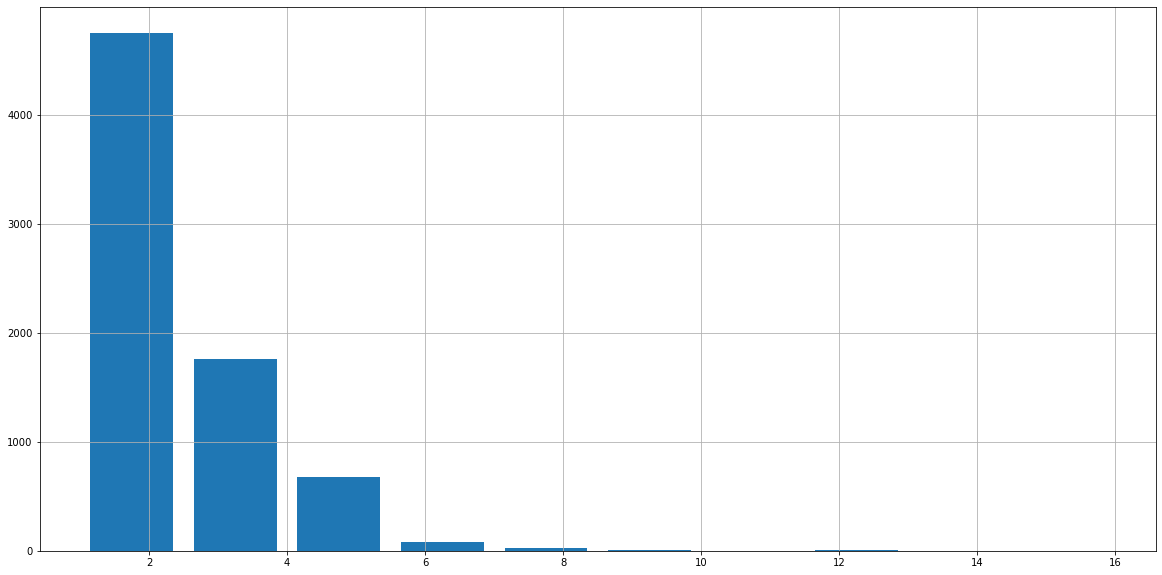

In [45]:
df8['bath'].hist(rwidth=0.8)

In [46]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


### 4BHK houses with 7 bathrooms or similar such data seems inconsistent
### we will consider these as outliers

In [47]:
df9 = df8[df8.bath<=df8.bhk+2]
df9.shape

(7313, 7)

* price per sqft can now be dropped, since its only use was for detecting outliers

In [48]:
df10 = df9.drop(['price_per_sqft'], axis='columns')
df10.head()

,location,size,total_sqft,bath,price,bhk
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2


## Model Building

### location column is string data, which cannot be used in building a model
### convert that into numerical data using One Hot Encoding

In [49]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df11 = pd.concat([df10, dummies.drop('other', axis='columns')], axis='columns')
df11.head()

,location,size,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### location column is now covered by one hot encoding and can be dropped now

In [51]:
df12 = df11.drop(['location'], axis='columns')
df12.head()

,size,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,4 BHK,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3 BHK,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3 BHK,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3 BHK,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2 BHK,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
df12.shape

(7313, 245)

In [53]:
X = df12.drop(['price', 'size'], axis='columns')
y = df12.price

In [54]:
X.head()

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

### split into training and test data

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Create Linear Regression Model

In [57]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8100855727729294

### use K-Fold cross validation to try and get a more accuraate model

In [58]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.86801733, 0.84558034, 0.83182627, 0.83917255, 0.86424179])

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best(X, y):
    algos = {
        'LinearRegression':{
            'model':LinearRegression(),
            'params':{
                'normalize':[True, False]
            }
        },
        
        'Lasso':{
            'model':Lasso(),
            'params':{
                'alpha':[1,2],
                'selection':['random', 'cyclic']
            }
        },
        
        'DecisionTreeRegressor':{
            'model':DecisionTreeRegressor(),
            'params':{
                'criterion':['mse', 'friedman_mse'],
                'splitter':['best', 'random']
            }
        }
    }
    score = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        score.append({
            'model':algo_name,
            'best_score':gs.best_score_,
            'best_params':gs.best_params_
        })
        
    return pd.DataFrame(score, columns=['model', 'best_score', 'best_params'])

In [60]:
find_best(X, y)

,model,best_score,best_params
0,LinearRegression,0.849768,{'normalize': True}
1,Lasso,0.701200,"{'alpha': 1, 'selection': 'cyclic'}"
2,DecisionTreeRegressor,0.746219,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


### Best model seems to be LinearRegression, with normalization True

In [61]:
def predict_price(location, sqft, bath, bhk):
    loc_index = np.where(X.columns==location)[0][0]
    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    
    if loc_index >= 0:
        x[loc_index] = 1
        
    return lr.predict([x])[0]


### Predicting the price

In [62]:
predict_price("Rajaji Nagar", 1000, 2, 2)

217.39627384428164

In [63]:
predict_price("Rajaji Nagar", 1000, 3, 3)

217.22500824972272

In [64]:
import pickle

with open('house_predict_pickle.pickle', 'wb') as f:
    pickle.dump(lr, f)
    

In [65]:
import json

columns = {
    'data_cloumns':[col.lower() for col in X.columns]
}

with open('columns.json', 'w') as f:
    f.write(json.dumps(columns))

In [ ]:
df10.head()

In [ ]:
df10.plot(x='bhk', y='total_sqft', kind='scatter')